## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample

import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model

from scipy.signal import find_peaks

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
36476,00009611_000.png,No Finding,0,9611,57,M,PA,2500,2048,0.168,0.168,NaN,/data/images_005/images/00009611_000.png
10943,00002843_014.png,Effusion,14,2843,56,F,PA,2500,2048,0.171,0.171,NaN,/data/images_002/images/00002843_014.png
31909,00008342_022.png,No Finding,22,8342,36,F,PA,2894,2991,0.143,0.143,NaN,/data/images_004/images/00008342_022.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        
print(all_xray_df.columns)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
80245,00019723_006.png,No Finding,6,19723,77,F,PA,2706,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
98949,00026167_003.png,Atelectasis|Effusion|Infiltration,3,26167,18,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
49305,00012505_005.png,Pleural_Thickening,5,12505,64,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

CLASS_NAME = 'pneumonia_class'
CLASS_ORIG_COL_NAME = 'Pneumonia'
BATCH_SIZE = 10
IMG_SIZE = (224, 224)

if CLASS_NAME in all_xray_df.columns:
    all_xray_df.drop(columns=[CLASS_NAME], inplace=True)
all_xray_df[CLASS_NAME] = 'NP'
all_xray_df.loc[all_xray_df[CLASS_ORIG_COL_NAME]==1, CLASS_NAME] = 'P'

all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NP
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NP
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NP
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NP
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NP


## Create your training and testing data:

In [5]:
def create_splits(df, test_ratio=0.2, test_set_positive_ratio=0.2):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
 
    train_df, valid_df = skl.train_test_split(df, 
                                   test_size = test_ratio, 
                                   stratify = df[CLASS_ORIG_COL_NAME])
    
    train_ratio = train_df[CLASS_ORIG_COL_NAME].sum() / train_df.shape[0]
    val_ratio = valid_df[CLASS_ORIG_COL_NAME].sum() / valid_df.shape[0]
    print(f"train = {train_df[CLASS_ORIG_COL_NAME].sum()} / {train_df.shape[0]} = {train_ratio}")
    print(f"validation = {valid_df[CLASS_ORIG_COL_NAME].sum()} / {valid_df.shape[0]} = {val_ratio}")
          
    p_inds = train_df[train_df[CLASS_ORIG_COL_NAME]==1].index.tolist()
    np_inds = train_df[train_df[CLASS_ORIG_COL_NAME]==0].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
          
        
    p_inds = valid_df[valid_df[CLASS_ORIG_COL_NAME]==1].index.tolist()
    np_inds = valid_df[valid_df[CLASS_ORIG_COL_NAME]==0].index.tolist()

    # The following code pulls a random sample of non-pneumonia data that's X times as big as the pneumonia sample.
    np_sample = sample(np_inds, round((1-test_set_positive_ratio)/test_set_positive_ratio*len(p_inds)))
    valid_df = valid_df.loc[p_inds + np_sample]
          
    train_ratio = train_df[CLASS_ORIG_COL_NAME].sum() / train_df.shape[0]
    val_ratio = valid_df[CLASS_ORIG_COL_NAME].sum() / valid_df.shape[0]
    print(f"train = {train_df[CLASS_ORIG_COL_NAME].sum()} / {train_df.shape[0]} = {train_ratio}")
    print(f"validation = {valid_df[CLASS_ORIG_COL_NAME].sum()} / {valid_df.shape[0]} = {val_ratio}")
          
    # return train_data, val_data
    return train_df, valid_df

In [6]:
train_data, val_data = create_splits(all_xray_df, test_ratio=0.2, test_set_positive_ratio=0.2)

train = 1145.0 / 89696 = 0.012765340706386016
validation = 286.0 / 22424 = 0.012754191937210132
train = 1145.0 / 2290 = 0.5
validation = 286.0 / 1430 = 0.2


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return my_idg


def make_train_gen(train_df, batch_size=9):
    my_train_idg = my_image_augmentation()
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
   
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = CLASS_NAME,
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = batch_size
                                         )

    return train_gen


def make_val_gen(val_data, batch_size=9):
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0,)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = CLASS_NAME,
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = batch_size) 
    
    return val_gen

In [8]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data, batch_size=BATCH_SIZE)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.


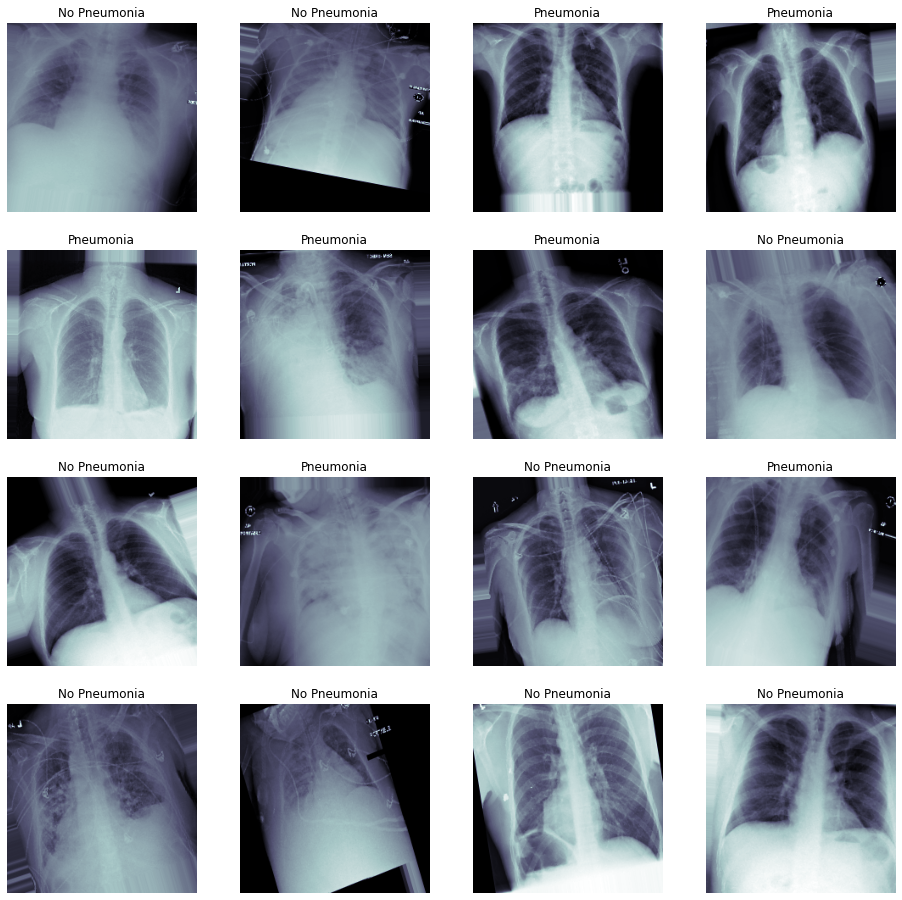

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
train_gen = make_train_gen(train_data, batch_size=4*BATCH_SIZE)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [10]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                       outputs=transfer_layer.output)
    
    for layer in vgg_model.layers[0:18]:
        layer.trainable = False
    
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
    
    return vgg_model


In [11]:
def build_my_model(learning_rate=1e-4):
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    vgg_model = load_pretrained_model()
    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=learning_rate)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']

    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [12]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only = True)

early = EarlyStopping(monitor='val_binary_accuracy', 
                      mode='max', 
                      patience=BATCH_SIZE)

callbacks_list = [checkpoint, early]

### Start training! 

In [13]:
## train your model

my_model = build_my_model()
history = my_model.fit_generator(train_gen, 
                      validation_data = (valX, valY), 
                      epochs = 100, 
                      callbacks = callbacks_list)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True
Epoch 1/100
58/58 [==============================] - 66s 1s/step - loss: 0.8169 - binary_accuracy: 0.5031 - val_loss: 0.6788 - val_binary_accuracy: 0.5000

Epoch 00001: val_binary_accuracy improved from -inf to 0.50000, saving model to xray_class_my_model.best.hdf5
Epoch 2/100
58/58 [==============================] - 60s 1s/step - loss: 0.7600 - binary_accuracy: 0.5349 - val_loss: 0.7274 - val_binary_accuracy: 0.4000

Epoch 00002: val_binary_accuracy did not improve from 0.50000
Epoch 3/100
58/58 [==============================] - 61s 1s/step - loss: 0.7470 - binary_accuracy: 0.5057 - val_loss: 0.8056 - val_binary_accuracy: 0.2000

Epoch 0000

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [14]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
## train your model

my_model = build_my_model()
my_model.load_weights(weight_path)

val_gen = make_val_gen(val_data, batch_size=100)

total_valY = []
total_predY = []

for i in range(10):
    valX, valY = val_gen.next()
    pred_Y = my_model.predict(valX, batch_size=100, verbose = True)
    
    total_valY.extend(valY.copy())
    total_predY.extend(pred_Y.copy())
# valY

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True
Found 1430 validated image filenames belonging to 2 classes.
100/100 [==============================] - 1s 10ms/step


In [15]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area= %0.2f)'%roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    return

## what other performance statistics do you want to include here besides AUC? 
def calc_f1(prec, recall):
    return 2*(prec*recall)/(prec+recall)

def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,2, figsize = (15, 5))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax[0].plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax[0].legend()
    c_ax[0].set_xlabel('Recall')
    c_ax[0].set_ylabel('Precision')
    
    f1 = calc_f1(precision, recall)
    c_ax[1].plot(thresholds, f1[:-1])
    c_ax[1].set_xlabel('Threshold')
    c_ax[1].set_ylabel('F1')

    dist_num = int(f1.size * 0.1)
    idx, _ = find_peaks(f1, height=0, distance=dist_num)
    print(f"dnum={dist_num} i={idx}, f1={f1[idx]}, threshold={thresholds[idx]}")
    
    return (f1[idx], thresholds[idx])
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    
    return

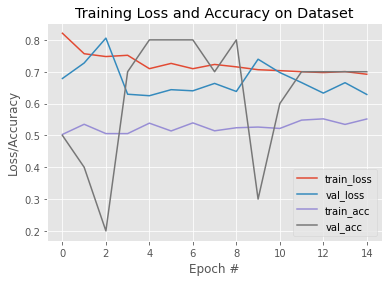

In [16]:
plot_history(history)
# if the history plot is overwritten, please refer to the image snapshot at FDA Submission Template

dnum=98 i=[ 52 158 284 402 503 632 733 843 943], f1=[0.35325132 0.36434109 0.37969095 0.39847716 0.40756914 0.40143369
 0.38074398 0.28242075 0.12145749], threshold=[0.38417244 0.4032013  0.42015743 0.43714482 0.4488648  0.46230912
 0.47515437 0.4923227  0.52185327]


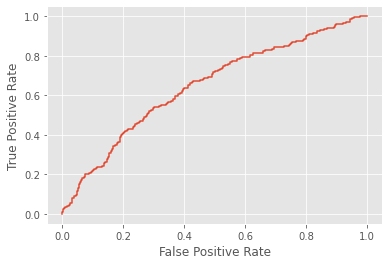

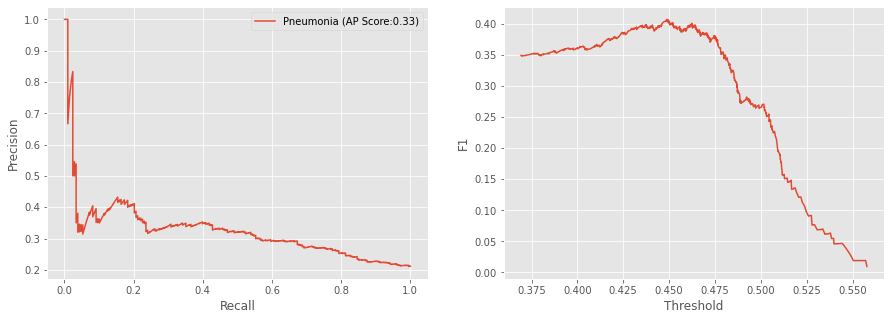

In [17]:
## plot figures

plot_auc(total_valY, total_predY)

f1s, thresholds = plot_precision_recall_curve(total_valY, total_predY)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [18]:
def get_score(y_true, y_pred):
    scores = {}
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    
    scores['sens'] =  tp/(tp+fn)
    scores['spec'] =  tn/(tn+fp)
    scores['prec'] =  tp/(tp+fp)
    scores['f1'] = f1_score(y_true, y_pred)
    scores['acc'] = (tp+tn) / (tp+tn+fp+fn)
    
    return scores

In [19]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

for i in thresholds:
    print(f"threshold={i}, {get_score(np.array(total_valY), np.array(total_predY) > i)}")

threshold=0.3841724395751953, {'sens': 0.9615384615384616, 'spec': 0.07954545454545454, 'prec': 0.21528525296017223, 'f1': 0.3518029903254178, 'acc': 0.263}
threshold=0.40320131182670593, {'sens': 0.8990384615384616, 'spec': 0.19696969696969696, 'prec': 0.22721749696233293, 'f1': 0.3627546071774975, 'acc': 0.343}
threshold=0.42015743255615234, {'sens': 0.8221153846153846, 'spec': 0.33585858585858586, 'prec': 0.24533715925394547, 'f1': 0.3779005524861878, 'acc': 0.437}
threshold=0.43714481592178345, {'sens': 0.75, 'spec': 0.4659090909090909, 'prec': 0.2694300518134715, 'f1': 0.3964421855146124, 'acc': 0.525}
threshold=0.44886478781700134, {'sens': 0.6682692307692307, 'spec': 0.571969696969697, 'prec': 0.2907949790794979, 'f1': 0.40524781341107874, 'acc': 0.592}
threshold=0.4623091220855713, {'sens': 0.5336538461538461, 'spec': 0.6994949494949495, 'prec': 0.31805157593123207, 'f1': 0.3985637342908438, 'acc': 0.665}
threshold=0.4751543700695038, {'sens': 0.41346153846153844, 'spec': 0.795

0.4488648 0.4075691411935954


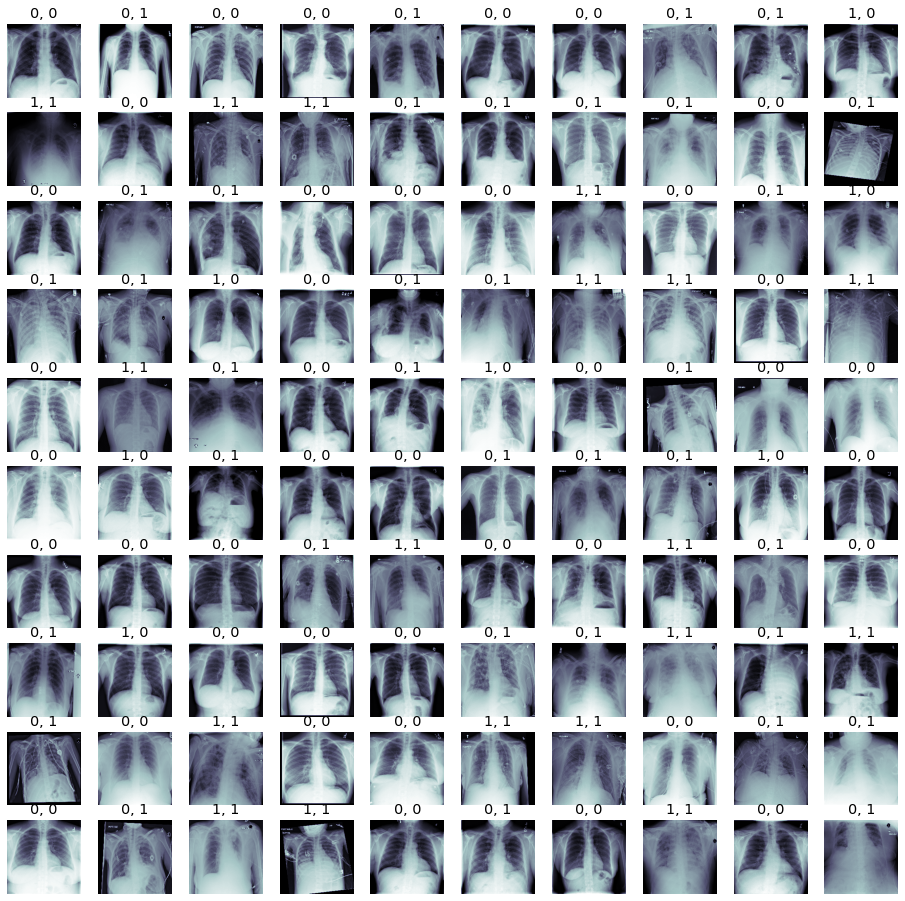

In [22]:
## Let's look at some examples of true vs. predicted with our best model: 
YOUR_THRESHOLD = thresholds[np.argmax(f1s)]
print(YOUR_THRESHOLD, f1s[np.argmax(f1s)])
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [21]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)
    
# plot_model(my_model, to_file="my_model.png", show_shapes=True)